In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

In [6]:
def indices_sampler(sample_rate, indices):
    target_samples = int(len(indices) * sample_rate)
    selected_indices = np.linspace(0, len(indices) - 1, target_samples, dtype=int)
    return selected_indices

class MaskingAnalysis:
    def __init__(self, checkpoint_name):
        self.checkpoint_name = checkpoint_name
        self.csv_path = Path(f"checkpoints/{checkpoint_name}/csv")
        self.continuous_masking = self.get_masking_data("continuous")
        self.random_masking = self.get_masking_data("random")
    
    def get_masking_data(self, masking_type):
        all_path = self.csv_path.rglob(f"{masking_type}_masking.csv")
        all_path = list(sorted(all_path, key = lambda p: int(p.parts[-2].split("_")[-1])))
        with open(next(iter(all_path)), 'r') as f:
            channels = f.readline().strip().split(',')[2:]
        mask_len = np.genfromtxt(next(iter(all_path)), delimiter= ',', skip_header=1, usecols=1, dtype=float)
        epochs = np.array([int(path.parts[-2].split("_")[-1]) for path in all_path])
        masks = []
        for _path in all_path:
            masking = np.genfromtxt(_path, delimiter= ',', skip_header=1, usecols=range(2, len(channels) + 2))
            masks.append(masking)
        return [np.stack(masks), mask_len, channels, epochs]
    
    def plot_ssim_epoch(self, sample_rate_continuous=1, sample_rate_random=1):
        sampled_indices_continuous = indices_sampler(sample_rate_continuous, self.continuous_masking[1])
        sampled_indices_random = indices_sampler(sample_rate_random, self.random_masking[1])
        plt.figure(figsize=(len(self.continuous_masking[2]) * 5, 8)) 
        
        for i, _c in enumerate(self.continuous_masking[2]):
            plt.subplot(2, len(self.continuous_masking[2]), i + 1) 
            plt.plot(self.continuous_masking[3],self.continuous_masking[0][:, sampled_indices_continuous, i])
            plt.legend(self.continuous_masking[1][sampled_indices_continuous],loc = "lower right")
            plt.xlabel("Epoch")
            plt.ylabel("SSIM")
            plt.title(f"Continuous Masking:{_c}")
        
        for i, _c in enumerate(self.random_masking[2]):
            plt.subplot(2, len(self.random_masking[2]), i + 5) 
            plt.plot(self.random_masking[3],self.random_masking[0][:, sampled_indices_random, i])
            plt.legend(self.random_masking[1][sampled_indices_random],loc = "lower right")
            plt.xlabel("Epoch")
            plt.ylabel("SSIM")
            plt.title(f"Random Masking:{_c}")
        plt.tight_layout()
        plt.show()
    
    def plot_ssim_cs(self):
        plt.figure(figsize=(5, 10))
        plt.subplot(2, 1, 1)
        plt.plot(self.continuous_masking[1],self.continuous_masking[0][-1,:,:])
        plt.legend(self.continuous_masking[2],loc = "lower left")
        plt.xlabel("Continuous Mask Length")
        plt.ylabel("SSIM")
        plt.title("Continuous Masking")
        plt.subplot(2, 1, 2)
        plt.plot(self.random_masking[1],self.random_masking[0][-1,:,:])
        plt.legend(self.random_masking[2],loc = "lower left")
        plt.xlabel("Random Mask Rate")
        plt.ylabel("SSIM")
        plt.title("Random Masking")
        plt.tight_layout()
        plt.show()

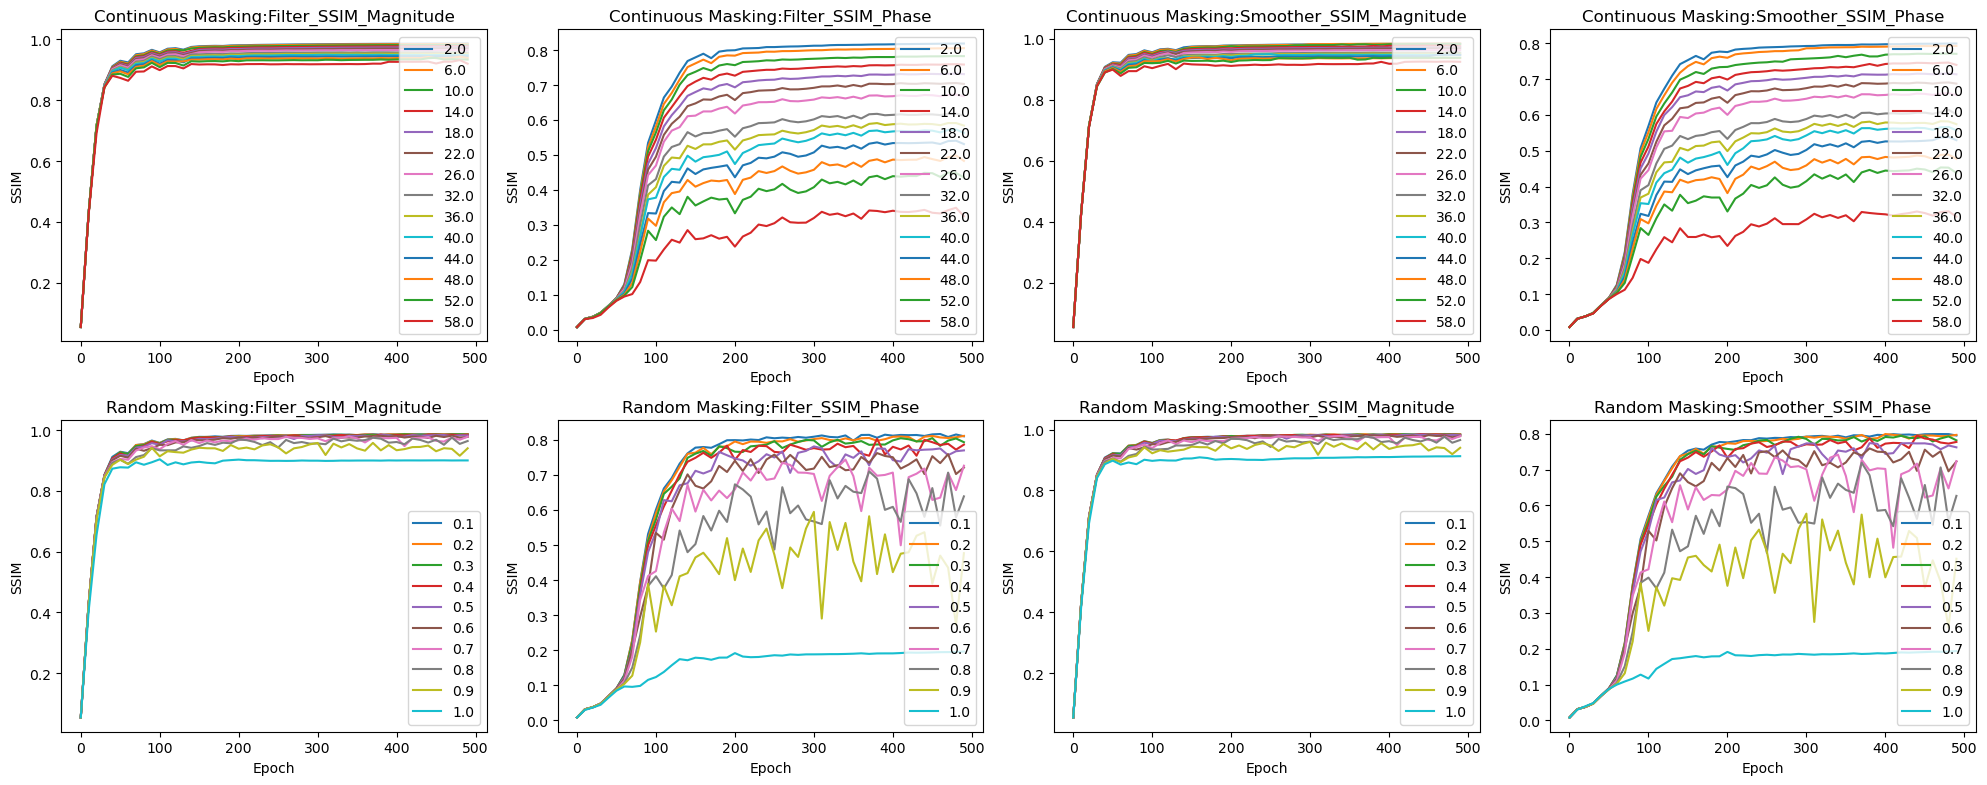

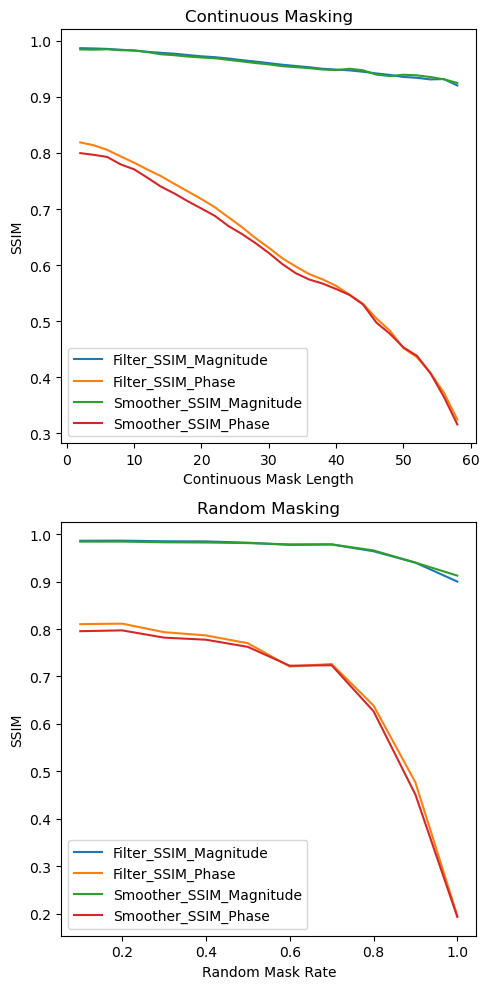

In [9]:
MA = MaskingAnalysis("20240831_215450")
# MA.continuous_masking[2] = MA.random_masking[2] = ["Filter_SSIM_Real", "Filter_SSIM_Imaginary", "Smoother_SSIM_Real", "Smoother_SSIM_Imaginary"]
MA.continuous_masking[2] = MA.random_masking[2] = ["Filter_SSIM_Magnitude", "Filter_SSIM_Phase", "Smoother_SSIM_Magnitude", "Smoother_SSIM_Phase"]
MA.plot_ssim_epoch(0.5, 1)
MA.plot_ssim_cs()